In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import seaborn as sns

# Set up paths
video_dir = Path("../examples")
model_dir = Path("../model/VideoMAEv2-Base")

# Get sample video files
video_files = sorted(list(video_dir.glob("*.mp4")))[:3]
print(f"Found {len(video_files)} sample videos:")
for vf in video_files:
    print(f"  - {vf.name}")


Found 3 sample videos:
  - v_--1DO2V4K74.mp4
  - v_3ImTO0bzXPA.mp4
  - v_ccKJg_f1UDo.mp4


In [ ]:
# Display sample videos
print("\nSample Videos:")
for video_file in video_files:
    print(f"\n{video_file.name}")
    display(Video(str(video_file), width=400))


In [26]:
# Load VideoMAEv2 model
from transformers import AutoModel
import sys
sys.path.append(str(model_dir))

print("Loading VideoMAEv2 model...")
model = AutoModel.from_pretrained(str(model_dir), trust_remote_code=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()
print(f"Model loaded on {device}")


Loading VideoMAEv2 model...
Model loaded on cuda


In [27]:
def load_video(video_path, num_frames=16, img_size=224):
    """Load video and extract frames."""
    cap = cv2.VideoCapture(str(video_path))
    frames = []
    
    # Get total frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Sample frames uniformly
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            # Convert BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Resize
            frame = cv2.resize(frame, (img_size, img_size))
            # Normalize to [-1, 1] as per model config (mean=0.5, std=0.5)
            frame = (frame / 255.0 - 0.5) / 0.5
            frames.append(frame)
    
    cap.release()
    
    # Convert to tensor: (T, H, W, C) -> (C, T, H, W)
    video_tensor = torch.FloatTensor(np.array(frames))
    video_tensor = video_tensor.permute(3, 0, 1, 2)
    
    return video_tensor, total_frames

print("Video loading function defined")


Video loading function defined


In [28]:
# Generate embeddings for each video
embeddings_list = []
video_info = []

print("Generating embeddings...")
for video_file in video_files:
    print(f"\nProcessing: {video_file.name}")
    
    # Load video
    video_tensor, total_frames = load_video(video_file)
    video_tensor = video_tensor.unsqueeze(0).to(device)  # Add batch dimension
    
    # Generate embeddings
    with torch.no_grad():
        embeddings = model.extract_features(video_tensor)
    
    # Move to CPU and convert to numpy
    embeddings_np = embeddings.cpu().numpy()
    
    embeddings_list.append(embeddings_np)
    video_info.append({
        'name': video_file.name,
        'total_frames': total_frames,
        'embedding_shape': embeddings_np.shape
    })
    
    print(f"  Total frames: {total_frames}")
    print(f"  Embedding shape: {embeddings_np.shape}")

print("\nDone generating embeddings!")


Generating embeddings...

Processing: v_--1DO2V4K74.mp4
  Total frames: 6338
  Embedding shape: (1, 768)

Processing: v_3ImTO0bzXPA.mp4


[h264 @ 0x414728c0] mmco: unref short failure


  Total frames: 5701
  Embedding shape: (1, 768)

Processing: v_ccKJg_f1UDo.mp4
  Total frames: 987
  Embedding shape: (1, 768)

Done generating embeddings!


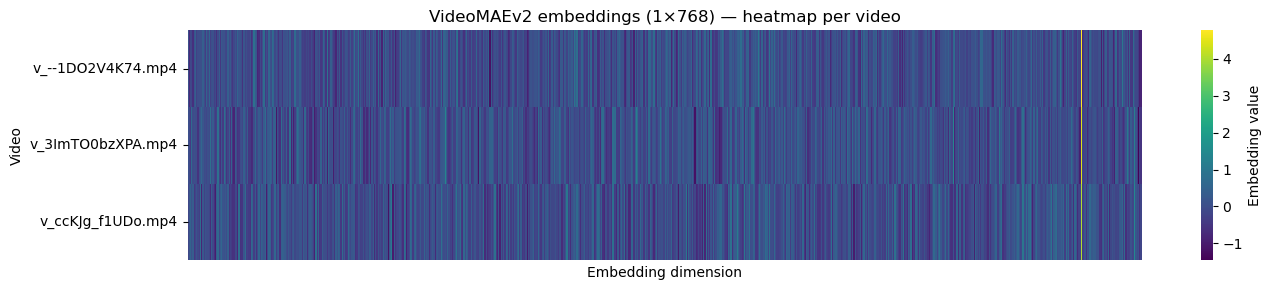

In [ ]:
# Embedding heatmap (one embedding per video)
# Each row is a video, each column is one embedding dimension.
emb_matrix = np.vstack([e.squeeze(0) for e in embeddings_list])  # (num_videos, 768)
video_names = [v["name"] for v in video_info]

plt.figure(figsize=(14, 1.2 + 0.6 * len(video_names)))
sns.heatmap(
    emb_matrix,
    cmap="viridis",
    yticklabels=video_names,
    xticklabels=False,
    cbar_kws={"label": "Embedding value"},
)
plt.xlabel("Embedding dimension")
plt.ylabel("Video")
plt.title("VideoMAEv2 embeddings (1x768) — heatmap per video")
plt.tight_layout()
plt.show()
